# Imports

In [1]:
import dataclasses, pickle, os, sys
from functools import partial
from pathlib import Path
import numpy as np
import jax, jax.numpy as jp, jax.random as rax, jax.tree_util as tu
import flax, flax.linen as nn, flax.serialization, flax.struct as struct
import matplotlib.pyplot as plt

stop = jax.lax.stop_gradient
deepmap = tu.tree_map

# Utilities

In [2]:
def take_about(k, xs):
  ys = [xs[i] for i in np.unique(np.round(np.linspace(0, len(xs) - 1, k)).astype("int"))]
  return ys
def eqzip(*xss):
  xss = list(map(list, xss))
  assert all(len(xs) == len(xss[0]) for xs in xss)
  return list(map(list, zip(*xss)))
def unzip2(xss):
  if not xss: return [], []
  return eqzip(*xss)
def rscope(rng, *path):
  # NOTE used to use seed = hash(path) but that is nondeterministic
  import zlib
  data = "/".join(map(str, path)).encode("ascii")
  seed = zlib.crc32(data)
  return rax.fold_in(rng, seed)
def params_rscope(rng, params):
  return flax.core.freeze(map_nested_dict(lambda path, param: rscope(rng, "/".join(map(str, path))),
                                          params))

def quantile_regression_loss(xs, ys):
  [n] = ys.shape
  if n == 1:  # do simple squared loss if single quantile
    return huber(xs-ys).mean()
  mid = (jp.arange(n) + 0.5) / n  # quantile midpoints
  dq = ys[None, :] - xs[:, None]
  loss = jp.abs(mid[:, None] - (dq<0)) * huber(dq)
  return loss.sum() / n

def huber(delta, threshold=1):
  delta = jp.abs(delta)
  return jp.where(delta <= threshold,
                  delta ** 2 / 2,
                  threshold * delta - threshold ** 2 / 2)

def value_and_naive_gradients(f):
  def fn(agents):
    y, df = jax.vjp(f, agents)
    [dydx] = jax.vmap(df)(jp.eye(2,dtype="float32"))
    dx = jp.einsum("ii...->i...", dydx)
    return y, dx
  return fn
def naive_gradients(f):
  def fn(agents):
    y, dx = value_and_naive_gradients(f)(agents)
    return dx
  return fn

from collections import abc
def iterate_nested_dict(node):
  if not isinstance(node, abc.Mapping):
    yield (), node
  else:
    for key, child in node.items():
      for path, leaf in iterate_nested_dict(child):
        yield (key, *path), leaf
def map_nested_dict(fn, node, path=()):
  if not isinstance(node, abc.Mapping):
    return fn(path, node)
  return {
    key: map_nested_dict(fn, child, (*path, key))
    for key, child in node.items()
  }
def map_params_dict(fn, node):
  return flax.core.freeze(map_nested_dict(fn, node))

In [3]:
@struct.dataclass
class VHatParameters:
  params: "Any"
  module: "Module" = struct.field(pytree_node=False)

  def __call__(self, agents, **kwargs):
    x = self.module.apply(dict(params=self.params), agents, **kwargs)
    return x.mean(axis=-1)

  def quantiles(self, agents, **kwargs):
    return self.module.apply(dict(params=self.params), agents, **kwargs)

  @classmethod
  def init(cls, module, rng):
    params = module.init(rng, init_agents(rax.PRNGKey(1)), gamma=jp.zeros([2], dtype="float32"))["params"]
    return cls(params, module)

  def rscope(self, rng):
    return self.replace(params=params_rscope(rng, self.params))
  def describe(self):  # show parameter shapes and sizes
    print("vhat params")
    for path, param in iterate_nested_dict(self.params):
      print("  ", "/".join(map(str, path)), param.shape, param.size)
    print("total vhat params", sum(param.size for param in tu.tree_leaves(self.params)))

@struct.dataclass
class AdamOptimizer:
  lr: float = struct.field(pytree_node=False, default=1e-3)
  eps: float = struct.field(pytree_node=False, default=1e-8)
  beta1: float = struct.field(pytree_node=False, default=0.9)
  beta2: float = struct.field(pytree_node=False, default=0.99)
  clip: "Any" = struct.field(pytree_node=False, default=None)
  decay: float = struct.field(pytree_node=False, default=0.01)
  moment1: "Any" = None
  moment2: "Any" = None
  n: int = 0

  @classmethod
  def make_for(cls, params, **hp):
    moment1 = deepmap(jp.zeros_like, params)
    moment2 = deepmap(jp.zeros_like, params)
    return cls(moment1=moment1, moment2=moment2, n=jp.array(0, dtype="int32"), **hp)

  def __call__(self, params, grad):
    if self.clip is not None:
      grad = deepmap(lambda dx: jp.clip(dx, -self.clip, +self.clip), grad)
    moment1 = deepmap(lambda m,dx: m + (1-self.beta1)*(dx-m), self.moment1, grad)
    moment2 = deepmap(lambda m,dx: m + (1-self.beta2)*(dx**2-m), self.moment2, grad)
    n = self.n + 1
    dbmoment1 = deepmap(lambda m: m / (1-self.beta1**n), moment1)
    dbmoment2 = deepmap(lambda m: m / (1-self.beta2**n), moment2)
    step = deepmap(lambda dm1,dm2,x: (self.lr*(dm1/(self.eps+dm2**0.5))
                                      -jp.abs(self.lr)*self.decay*x),
                   dbmoment1, dbmoment2, params)
    new_self = self.replace(moment1=moment1, moment2=moment2, n=n)
    return new_self, step

def apply_grads(optimizers, modules, grads):
  optimizers, steps = unzip2(opt(m, grad) for opt, m, grad in eqzip(optimizers, modules, grads))
  new_modules = [deepmap(lambda x, dx: x + dx, module, step)
                 for module, step in eqzip(modules, steps)]
  return optimizers, new_modules

# Game definition

In [4]:
GAME_DISCOUNT = 0.96
PAYOFFS = np.array([[-2,0,-3,-1],
                    [-2,-3,0,-1]]).T # [state, player]
def play_episode(agents, discount=GAME_DISCOUNT):
  pi = nn.sigmoid(agents)
  assert pi.shape == (2,5)
  pi = pi.at[1].set(pi[1,(0,1,3,2,4)])  # swap player 2 perspective
  pi = jp.stack([1-pi,pi], axis=-1) # [player, state, action]
  p0 = jp.einsum("a,b->ab", pi[0,0], pi[1,0]).reshape([4]) # initial state distribution
  P = jp.einsum("sa,sb->sab", pi[0,1:], pi[1,1:]).reshape([4,4])  # transition matrix
  I = jp.eye(4)
  effective_state = (1-discount)*p0@jp.linalg.inv(I-discount*P)
  returns = effective_state@PAYOFFS
  return dict(returns=returns, effective_state=effective_state,
              epstats=dict(zip("DD DC CD CC".split(), effective_state)))

def init_agents(rng, batch_shape=()):
  return rax.normal(rng, shape=[*batch_shape,2,5])

# Configuration

In [5]:
@struct.dataclass
class Hp:
  outer_lr: float = 1e-3
  alpha: float = 1/(1-GAME_DISCOUNT)
  fixed_gamma: str = None
  outer_num_steps: int = 500
  inner_num_steps: int = 100
  stride: int = 10
  batch_size: int = 128
  rho: float = 0.999
  lamda: float = 0.9
  seed: int = 1
  explore_policy: str = "noisy_vhat"
  behave_policy: str = "vhat"
  predict_target: int = 1  # whether to use target_vhat or vhat in bellman target
  semigradient: int = 1  # whether to stop gradient on bellman target
  correction_version: int = 1  # agents follow grad(f+gamma V), V=f'+gamma V'
  quantiles: int = 64

# during training, we maintain "outer agents" -- agents that follow gradients of
# the model without any exploration and with fixed gamma. this allows us to
# monitor the performance while training.
#OAGENT_GAMMAS = {s: float(f"0.{s}") for s in "90 95 99".split()}
OAGENT_GAMMAS = {s: float(f"0.{s}") for s in "95".split()}

# Architecture

In [6]:
class VHat(nn.Module):
  size: int = 128
  quantiles: int = 64
  normalize: int = 1

  @nn.compact
  def __call__(self, agents, gamma, explore_rng=None, explore_level=0.):
    zpolicy = nn.sigmoid(agents)  # [player, features]
    zpolicy = nn.gelu(nn.Dense(self.size, name="embed")(zpolicy))
    zpolicy = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="zpolicy")(zpolicy))

    zgamma = nn.gelu(nn.Dense(self.size, name="zgamma")(gamma[:,None]))

    z = jp.concatenate([zpolicy, zgamma], axis=-1)
    z = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="mix_gamma")(z))
    for layer in range(2):
      z = ResidualBlock(name=f"Q{layer}", normalize=self.normalize)(z)
    z = jp.concatenate([z, z[::-1]], axis=-1)
    z = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="mix_oppt")(z))
    for layer in range(2):
      z = ResidualBlock(name=f"R{layer}", normalize=self.normalize)(z)
    z = nn.tanh(DenseNorm(self.size, normalize=self.normalize, name="zfinal")(z))

    if explore_rng is not None: # flip sign on units to vary vhat for use in explore
      keep_prob = 1 - explore_level/2
      mask = rax.bernoulli(rscope(explore_rng, "latent_mask"), p=keep_prob, shape=z.shape)
      z = jp.where(mask, z, -z)  # [player, features]
    return nn.Dense(self.quantiles, name="output")(z) # [player, quantiles]

class DenseNorm(nn.Module):
  size: int
  normalize: int = 0

  @nn.compact
  def __call__(self, x):
    z = nn.Dense(self.size, kernel_init=nn.initializers.orthogonal(),
                 name="d", use_bias=not self.normalize)(x)
    if self.normalize:
      z = nn.LayerNorm(name="n")(z)
    return z

class ResidualBlock(nn.Module):
  normalize: int = 0

  @nn.compact
  def __call__(self, x):
    size = x.shape[-1]
    z = nn.gelu(DenseNorm(size, name="X", normalize=self.normalize)(x))
    y = nn.Dense(size, name=f"H")(z)
    gate = nn.sigmoid(self.param("G", nn.initializers.zeros, [z.shape[-1]]))
    return gate*x + (1-gate)*y

# Training functions

In [7]:
@struct.dataclass
class TrainState:
  step: int
  flat_step: int
  rng: "PRNGKey"
  vhat: "VHatParameters"
  target_vhat: "VHatParameters"
  optimizer: "AdamOptimizer"
  oagentss: "List[array(batch,2,5)]"

  @classmethod
  def make(cls, hp):
    rng = rax.PRNGKey(hp.seed)
    oagentss = cls._init_oagents(rscope(rng, "init_oagents"), hp)
    vhat = VHatParameters.init(VHat(quantiles=hp.quantiles), rng=rscope(rng, "vhat"))
    target_vhat = VHatParameters.init(VHat(quantiles=hp.quantiles), rng=rscope(rng, "tvhat"))
    optimizer = AdamOptimizer.make_for(vhat, lr=-hp.outer_lr)
    state = cls(step=jp.array(0), flat_step=jp.array(0), rng=rscope(rng, "train"),
                vhat=vhat, target_vhat=target_vhat, optimizer=optimizer,
                oagentss=oagentss)
    return state

  def pop_rng(self):
    rng, elt = rax.split(self.rng)
    return self.replace(rng=rng), elt

  @classmethod
  def _init_oagents(cls, rng, hp):
    # for each OAGENT_GAMMAS, init a stacked batch of agents
    oagentss = [init_agents(rscope(rng, gammastr), [hp.batch_size])
                for gammastr, gamma in OAGENT_GAMMAS.items()]
    return oagentss
  def reset_oagents(self, rng, hp):
    oagentss = self._init_oagents(rng, hp)
    return self.replace(oagentss=oagentss)

def train(hp):
  def draw_gamma(rng, shape=()):
    if hp.fixed_gamma is not None:
      gamma = float(f"0.{hp.fixed_gamma}")
      return jp.full(shape, gamma)
    return rax.beta(rng, 0.5, 0.5, shape=shape)  # arcsin distribution

  def do_episode(agents, rng=None):
    episode = play_episode(agents)
    return episode["returns"], episode

  def prepare_vhat(vhat, gamma, context):
    vhat = partial(vhat, gamma=gamma)
    if not hp.correction_version: return vhat
    if context == "iagents": return vhat # just use vhat for explore
    def fn(agents):
      f, episode = do_episode(agents)
      vnext = vhat(agents)
      return (1-gamma)*f+gamma*vnext
    return fn

  @partial(jax.jit, donate_argnums=(1,))
  def update_iagents(ostate, istate, rng, gamma, explore_rng):
    @jax.vmap  # policy batch
    def fn(istate, rng, gamma, explore_rng):
      explore_level = 0.125
      vhat = dict(vhat=ostate.vhat,
                  target_vhat=ostate.target_vhat,
                  noisy_vhat=partial(ostate.vhat,
                                     explore_rng=rscope(explore_rng, "noisy_vhat"),
                                     explore_level=explore_level),
                  noisy_target_vhat=partial(ostate.target_vhat,
                                            explore_rng=rscope(explore_rng, "noisy_vhat"),
                                            explore_level=explore_level),
      )[hp.explore_policy]
      vhat = prepare_vhat(vhat, gamma, context="iagents")
      return do_inner_transitions(istate, vhat, rscope(rng, "inner_transition"), hp.stride)

    istates, epauxes = fn(istate, rax.split(rscope(rng, "inner_transition"), hp.batch_size),
                          gamma, rax.split(explore_rng, hp.batch_size))
    loss_fn = get_loss_fn(ostate, istates, [epaux["f"] for epaux in epauxes], gamma)
    loss, lossaux = loss_fn(ostate.vhat, rscope(rng, "model"))

    aux = dict(epstats=epauxes[0]["epstats"], f=epauxes[0]["f"],
               td=lossaux["td"], loss=loss)
    return istates[-1], aux

  @partial(jax.jit, donate_argnums=(0,))
  def update_vhat(ostate, istate, rng, gamma):
    @jax.vmap  # policy batch
    def fn(istate, rng, gamma):
      vhat = dict(vhat=ostate.vhat, target_vhat=ostate.target_vhat)[hp.behave_policy]
      vhat = prepare_vhat(vhat, gamma, context="vhat")
      istates, epauxes = do_inner_transitions(istate, vhat, rscope(rng, "inner_transition"), hp.stride)
      fs = [epaux["f"] for epaux in epauxes]
      return istates, epauxes, fs

    istates, epauxes, fs = fn(istate, rax.split(rscope(rng, "inner_transitions"), hp.batch_size), gamma)
    loss_fn = get_loss_fn(ostate, istates, fs, gamma)
    (loss, lossaux), grad = jax.value_and_grad(loss_fn, has_aux=True)(ostate.vhat, rscope(rng, "model"))
    new_optimizer, dvhat = ostate.optimizer(ostate.vhat, grad)
    new_vhat = deepmap(lambda x,dx:x+dx, ostate.vhat, dvhat)
    new_target_vhat = deepmap(lambda xbar,x: xbar+(1-hp.rho)*(x-xbar), ostate.target_vhat, new_vhat)

    new_ostate = ostate.replace(optimizer=new_optimizer, vhat=new_vhat, target_vhat=new_target_vhat)
    aux = dict(epstats=epauxes[0]["epstats"], f=epauxes[0]["f"],
               loss=loss, td=lossaux["td"],
               gradnorms=deepmap(lambda x: (x**2).mean(), grad))
    return new_ostate, aux
  @jax.jit
  def evaluate_longterm_error(ostate, istate, gamma):
    T = 100
    @jax.vmap  # policy batch
    def fn(istate, gamma):
      vhat = prepare_vhat(ostate.vhat, gamma, context="vhat")
      def body_fn(x, _):
        f,episode = do_episode(x)
        v,grads = value_and_naive_gradients(vhat)(x)
        x = x + hp.alpha * grads
        return x,(f,v)
      _,(fs,vs) = jax.lax.scan(body_fn, istate, None, length=T)
      fs = fs[1:] if hp.correction_version else fs[:-1]
      td = (1-gamma)*(gamma**jp.arange(len(fs))[:,None]*fs).sum(axis=0) + gamma**len(fs)*vs[-1] - vs[0]
      return td #[players]
    td = fn(istate, gamma)  # [batch,players]
    return (td**2).mean()**0.5

  def update_oagents(ostate, rng):
    new_oagentss = []; auxes = dict()
    for (gammastr, gamma), agents in eqzip(OAGENT_GAMMAS.items(), ostate.oagentss):
      new_agents, aux = _update_oagents(agents, ostate.target_vhat, rscope(rng, gammastr), gamma)
      new_oagentss.append(new_agents)
      auxes[gammastr] = aux
    return ostate.replace(oagentss=new_oagentss), auxes
  @partial(jax.jit, donate_argnums=(0))
  def _update_oagents(agents, vhat, rng, gamma):
    vhat = prepare_vhat(vhat, jp.full([2], gamma), context="oagents")
    @jax.vmap
    def fn(agents, rng):
      f, episode = do_episode(agents, rscope(rng, "episode"))
      v, grads = value_and_naive_gradients(vhat)(agents)
      agents = agents + hp.alpha * grads
      return agents, dict(episode=episode, epstats=episode["epstats"], f=f, v=v)
    return fn(agents, rax.split(rng, hp.batch_size))

  def do_inner_transitions(x, vhat, rng, n):
    xs = [x]; auxes = []
    for i in range(n):
      f, episode = do_episode(x)
      grads = naive_gradients(vhat)(x)
      x = x + hp.alpha * grads
      xs.append(x)
      auxes.append(dict(f=f, episode=episode, epstats=episode["epstats"]))
    f, episode = do_episode(x)
    auxes.append(dict(f=f, episode=episode, epstats=episode["epstats"]))
    return xs, auxes

  def get_loss_fn(ostate, istates, fs, gamma):
    def loss_fn_single(vhat, ostate, istates, fs, gamma):
      fs = fs[1:] if hp.correction_version else fs[:-1]

      T = len(istates)
      assert len(fs) + 1 == T
      rewards = jp.stack(fs) # [time,player]

      tvhat = ostate.target_vhat if hp.predict_target else vhat
      if hp.semigradient:
        tvhat = stop(tvhat)

      gg = gamma[...,None]  # dummy quantile axis
      if hp.lamda == 1:
        v = vhat.quantiles(istates[0], gamma=gamma)
        tv = tvhat.quantiles(istates[-1], gamma=gamma)

        prediction = v
        target = ((1-gg)*(gg**jp.arange(len(rewards))[:,None,None]*rewards[:,:,None]).sum(axis=0)  # [player,quantiles]
                  + gg**len(rewards)*tv)  # [player,quantiles]

        loss = jax.vmap(quantile_regression_loss)(prediction, target) # across player
        td0 = (target - prediction).mean(axis=-1) # [player]
      else:
        xs = deepmap(lambda *xs: jp.stack(xs), *[x for x in istates])  # agents with leading time axis
        vs = jax.vmap(partial(vhat.quantiles, gamma=gamma))(xs)  # [time,player,quantiles]
        tvs = jax.vmap(partial(tvhat.quantiles, gamma=gamma))(xs)  # [time,player,quantiles]

        # compute lamda-return by reverse scan
        def body_fn(target, inputs):
          [r,tv] = inputs
          target = (1-gg)*r + gg*((1-hp.lamda)*tv+hp.lamda*target)
          return target,target
        _, targets = jax.lax.scan(body_fn, tvs[-1], [rewards[::-1,...,None],tvs[1:][::-1]])
        targets = targets[::-1]
        predictions = vs[:-1]

        loss = jax.vmap(jax.vmap(quantile_regression_loss))(predictions, targets) # across time,player
        td0 = (1-gamma)*(gamma**jp.arange(len(rewards))[:,None]*rewards).sum(axis=0) + gamma**len(rewards)*vs[-1].mean(axis=-1) - vs[0].mean(axis=-1)

      return loss.mean(), dict(td=td0)

    def loss_fn(vhat, rng):
      loss, aux = jax.vmap(partial(loss_fn_single, vhat, ostate))(istates, fs, gamma)
      return loss.mean(), aux
    return loss_fn

  def try_exploit(candidates, rng, nsteps=300): # train a naive agent against fixed candidate
    opponents = init_agents(rscope(rng, "init"))
    assert opponents.shape == (2,5)
    for step in range(nsteps):
      rng, steprng = rax.split(rng)
      opponents, f = _try_exploit_step(candidates, opponents, steprng)
    return dict(f=f, opponents=opponents)
  @jax.jit
  @partial(jax.vmap, in_axes=(0,0,None))
  def _try_exploit_step(candidate, opponent, rng):
    def objective(opponent):
      agents = jp.stack([candidate, opponent])
      f, episode = do_episode(agents, rng)
      return f[1], f[0]
    (_, f0), grad = jax.value_and_grad(objective, has_aux=True)(opponent)
    new_opponent = opponent + hp.alpha * grad
    return new_opponent, f0

  log = []
  oalogs = {gammastr: [] for gammastr in OAGENT_GAMMAS}
  ostate = TrainState.make(hp)
  while ostate.step < hp.outer_num_steps:
    ostate, rng = ostate.pop_rng()

    isteps = list(range(0, hp.inner_num_steps, hp.stride))
    init_irng, *irngs = rax.split(rscope(rng, "inner_init"), 1 + len(isteps))
    istate = init_agents(rscope(init_irng, "agents"), [hp.batch_size])
    gamma_explore = draw_gamma(rscope(init_irng, "gamma"), shape=[hp.batch_size,2])
    explore_rng = rscope(init_irng, "explore")

    longterm_td = evaluate_longterm_error(ostate, istate, gamma_explore)
    xauxes = {gammastr: jax.vmap(try_exploit)(oagents, rax.split(rax.PRNGKey(1), hp.batch_size))
              for gammastr, oagents in eqzip(OAGENT_GAMMAS, ostate.oagentss)}

    first_vaux = None
    first_oauxes = None
    for istep, irng in eqzip(isteps, irngs):
      # advance inner agents by hp.stride steps
      istate, iaux = update_iagents(ostate, istate, rscope(irng, "update_iagents"), gamma_explore, explore_rng=explore_rng)

      # advance outer agents by as many steps
      for _ in range(hp.stride):
        ostate, oauxes = update_oagents(ostate, rscope(rng, "oagents"))
        first_oauxes = first_oauxes or oauxes

      ostate, vaux = update_vhat(ostate, istate, rscope(irng, "train"),
                                 draw_gamma(rscope(irng, "gamma"), shape=[hp.batch_size,2]))
      first_vaux = first_vaux or vaux

      ostate = ostate.replace(flat_step=ostate.flat_step + hp.stride)

    logframe = dict(
      loss=first_vaux["loss"],
      td=(first_vaux["td"] ** 2).mean()**0.5,
      longterm_td=longterm_td,
    )
    for gammastr in OAGENT_GAMMAS:
      logframe[f"o{gammastr}_f"] = first_oauxes[gammastr]["f"].mean(axis=0)
      logframe[f"o{gammastr}_x"] = xauxes[gammastr]["f"].mean(axis=0)
    log.append(logframe)

    ostate = ostate.replace(step=ostate.step + 1)
    if ostate.step % 10 == 0:
      print(ostate.step)
      # reset outer agents. first, print some information about the final outer agents
      for gammastr, oagents in eqzip(OAGENT_GAMMAS, ostate.oagentss):
        print("  outer agent stats", gammastr)
        oaux = oauxes[gammastr]
        print("    returns:", oaux["f"].mean(axis=0))
        print("    returns vs exploiters:", xauxes[gammastr]["f"].mean(axis=0))
        print("    expected state (DD DC CD CC):", np.array([oaux["epstats"][key].mean(axis=0) for key in "DD DC CD CC".split()]))
      ostate = ostate.reset_oagents(rscope(ostate.rng, "reset_oagents"), hp)

  return dict(ostate=ostate, log=log, oalogs=oalogs, hp=hp)

# Training

In [8]:
import pickle
cache_path = f"drive/MyDrive/metavalue/nbdata/ipd_ablation6"
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p {cache_path}
def cache_load(filename):
  try:
    with open(f"{cache_path}/{filename}.pkl", "rb") as file:
      return pickle.load(file)
  except FileNotFoundError:
    return None
def cache_save(obj, filename):
  with open(f"{cache_path}/{filename}.pkl", "wb") as file:
    pickle.dump(obj, file)

Mounted at /content/drive


In [9]:
!ls {cache_path}

default_seed0.pkl      no_explore_seed4.pkl  no_target_seed3.pkl
default_seed1.pkl      no_lamda_seed0.pkl    no_target_seed4.pkl
default_seed2.pkl      no_lamda_seed1.pkl    no_uhat_seed0.pkl
default_seed3.pkl      no_lamda_seed2.pkl    no_uhat_seed1.pkl
default_seed4.pkl      no_lamda_seed3.pkl    no_uhat_seed2.pkl
fixed_gamma_seed0.pkl  no_lamda_seed4.pkl    no_uhat_seed3.pkl
fixed_gamma_seed1.pkl  no_qrl_seed0.pkl      no_uhat_seed4.pkl
fixed_gamma_seed2.pkl  no_qrl_seed1.pkl      td0_seed0.pkl
fixed_gamma_seed3.pkl  no_qrl_seed2.pkl      td0_seed1.pkl
fixed_gamma_seed4.pkl  no_qrl_seed3.pkl      td0_seed2.pkl
no_explore_seed0.pkl   no_qrl_seed4.pkl      td0_seed3.pkl
no_explore_seed1.pkl   no_target_seed0.pkl   td0_seed4.pkl
no_explore_seed2.pkl   no_target_seed1.pkl
no_explore_seed3.pkl   no_target_seed2.pkl


In [10]:
import time

runs = dict()
def train_one(variation, hp):
  runs[variation] = []
  for seed in range(5):
    #run = None  ##### caching disabled!
    run = cache_load(f"{variation}_seed{seed}")
    if run is None:
      print("training seed", seed)
      time_start = time.perf_counter()
      run = train(hp.replace(seed=seed))
      time_end = time.perf_counter()
      print("seconds taken: ", f"{time_end-time_start:.4f}")
      cache_save(run, f"{variation}_seed{seed}")
    runs[variation].append(run)

train_one("default", Hp())
train_one("no_uhat", Hp(correction_version=0))
train_one("no_explore", Hp(explore_policy="vhat"))
train_one("no_target", Hp(predict_target=0, semigradient=0))
train_one("no_lamda", Hp(lamda=1))
train_one("no_qrl", Hp(quantiles=1))
train_one("fixed_gamma", Hp(fixed_gamma="95"))
train_one("td0", Hp(stride=1))

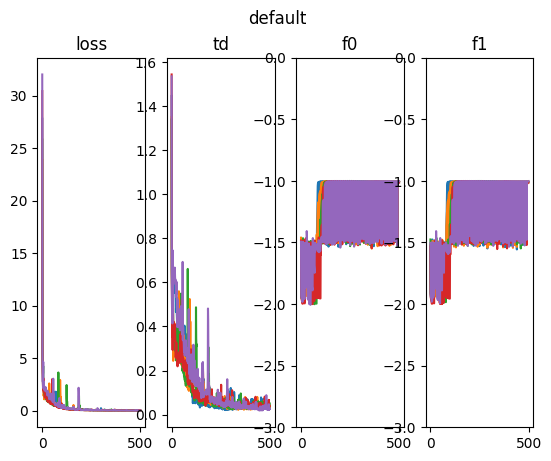

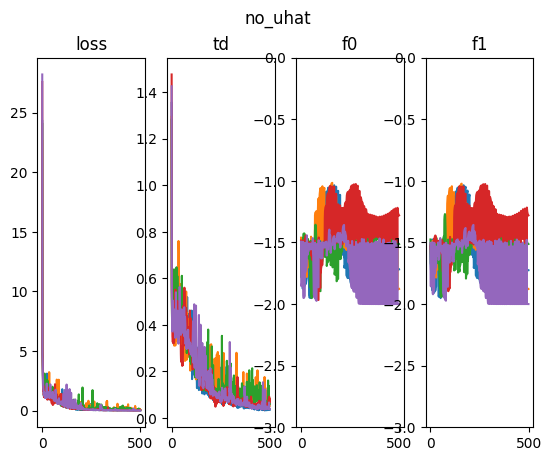

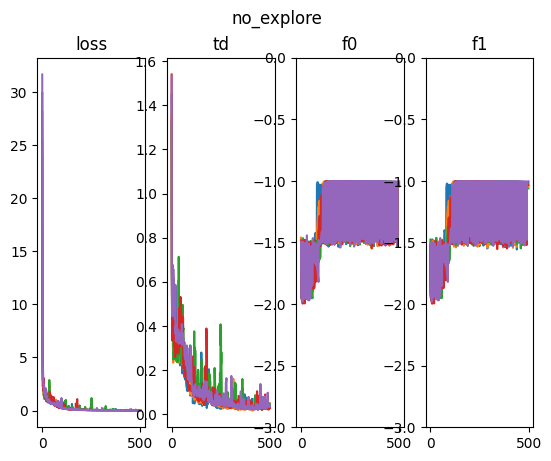

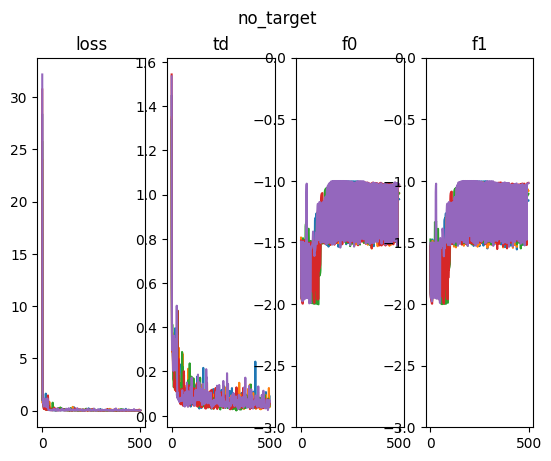

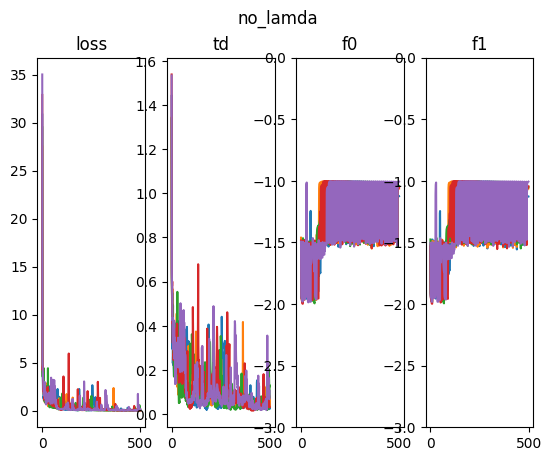

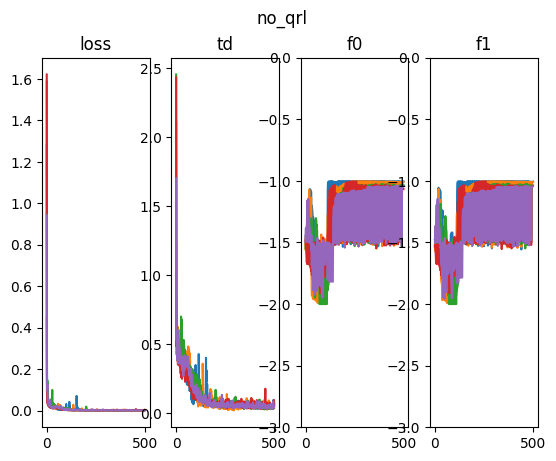

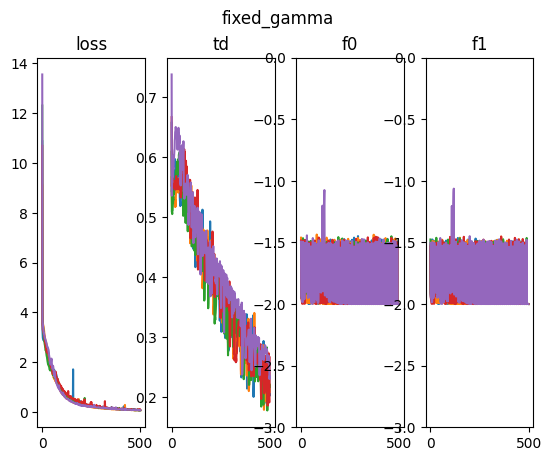

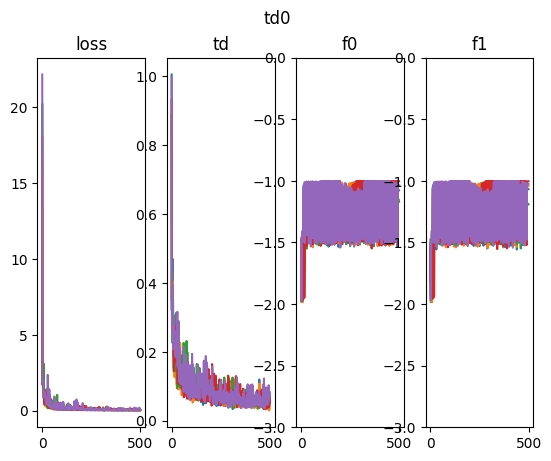

In [11]:
for variation, trials in runs.items():
  fig, axes = plt.subplots(1,4)
  for run in trials:
    seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])
    #seqs = deepmap(lambda xs: np.lib.stride_tricks.sliding_window_view(xs, 100).mean(axis=-1), seqs)
    axes[0].plot(seqs["loss"])
    axes[1].plot(seqs["td"])
    axes[2].plot(seqs["o95_f"][:,0])
    axes[3].plot(seqs["o95_f"][:,1])
  axes[0].set_title("loss")
  axes[1].set_title("td")
  axes[2].set_title("f0")
  axes[3].set_title("f1")
  #axes[0].set_ylim((0,0.05))
  #axes[1].set_ylim((0,0.1))
  axes[2].set_ylim((-3,0))
  axes[3].set_ylim((-3,0))
  fig.suptitle(variation)

default 0.03723628
no_explore 0.038777076
no_qrl 0.06034534
no_lamda 0.059174906
td0 0.05559089
no_target 0.04928746
no_uhat 0.05295936
fixed_gamma 0.22660105


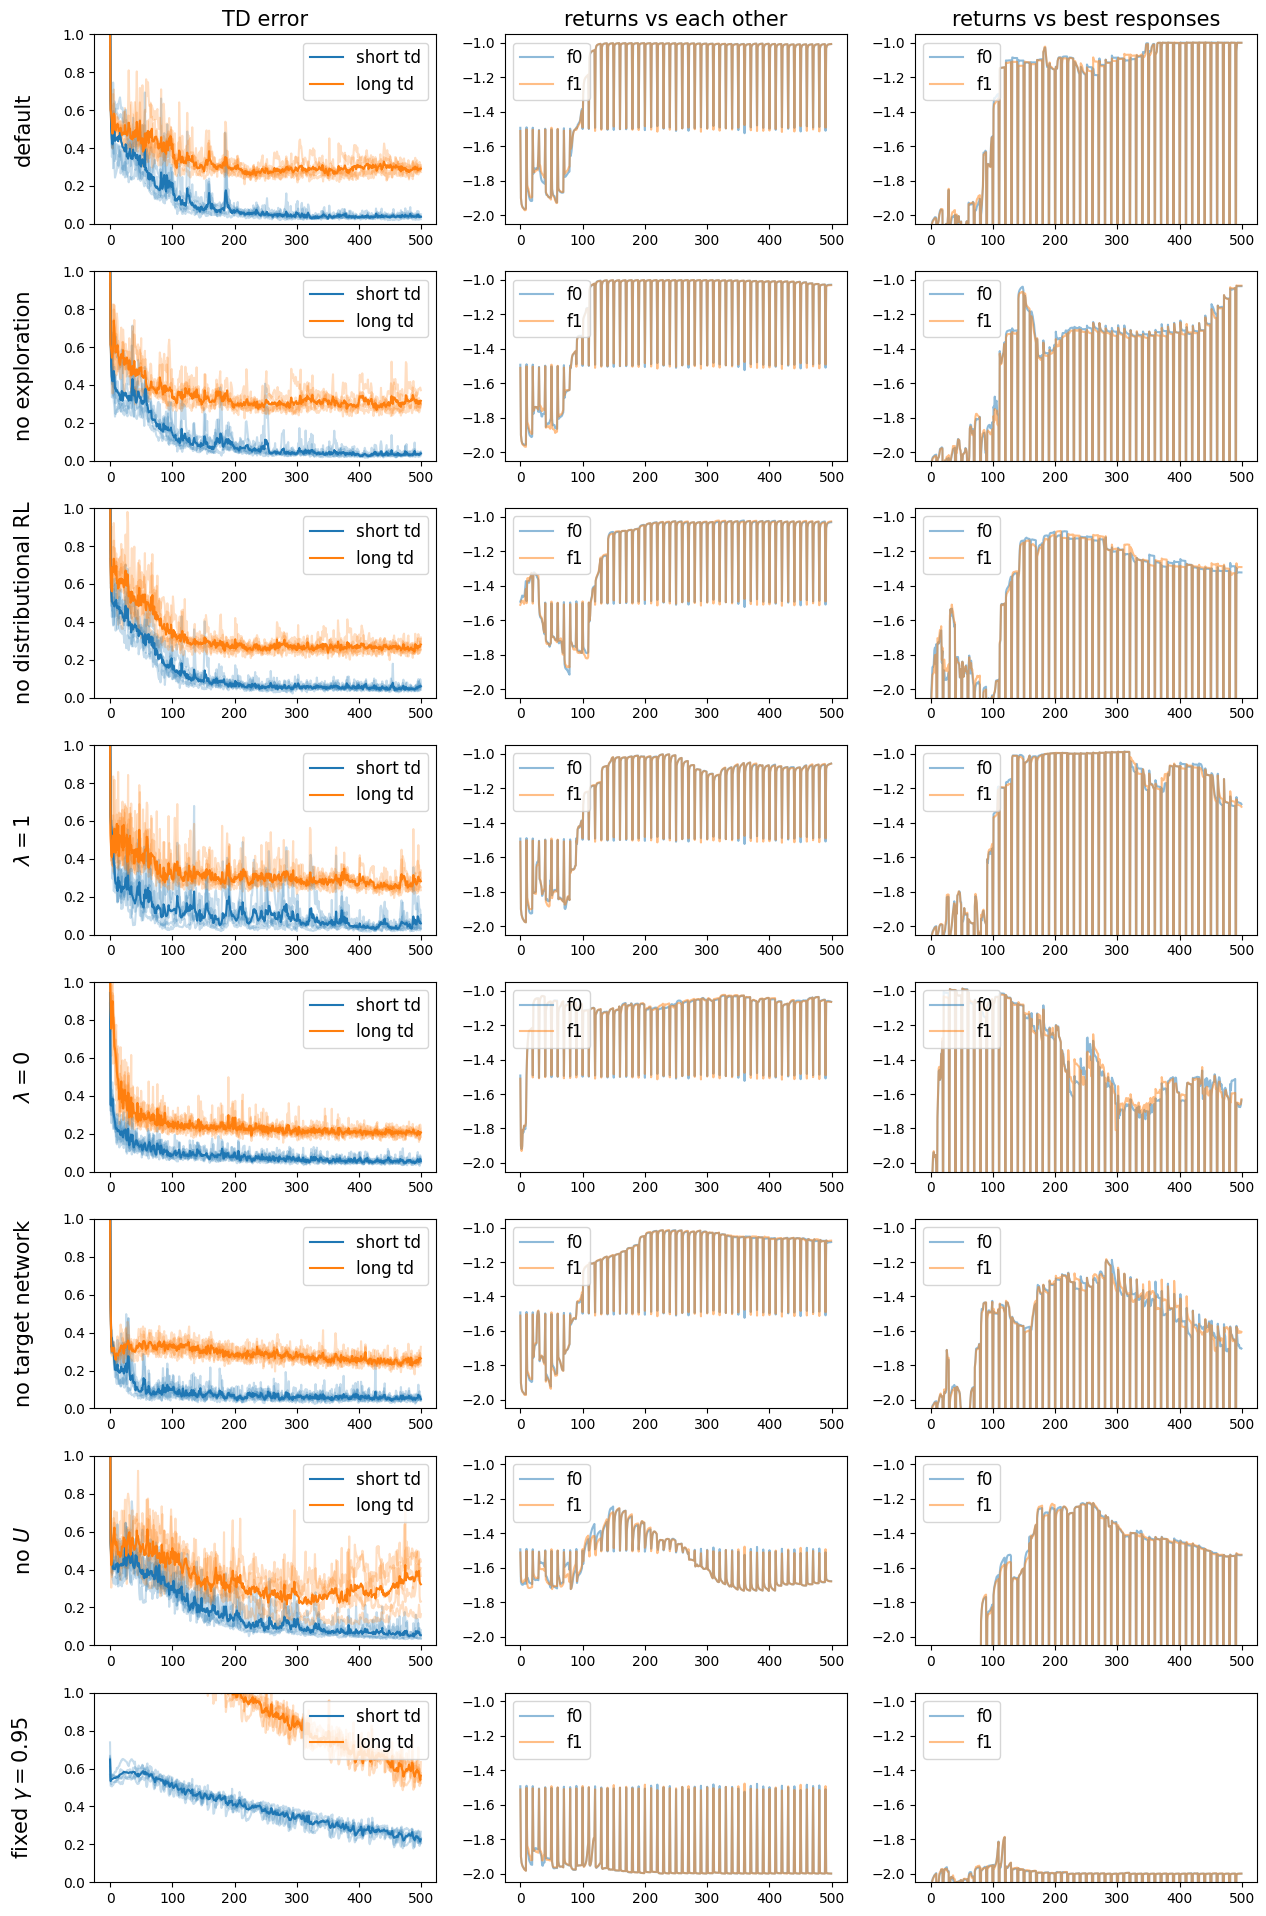

In [12]:
fig, axes = plt.subplots(len(runs),3,squeeze=False, figsize=(5*3,3*len(runs)))# figsize=(15,6))
variations = "default no_explore no_qrl no_lamda td0 no_target no_uhat fixed_gamma".split()
for i, variation in enumerate(variations):
  final_errors = []
  seqss = []
  for run in runs[variation]:
    seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])  # {k: [t]}
    seqss.append(seqs)
    final_errors.append(seqs["td"][-1])
    axes[i,0].plot(seqs["td"], alpha=0.25, color="tab:blue")
    axes[i,0].plot(seqs["longterm_td"], alpha=0.25, color="tab:orange")

  meanseq = deepmap(lambda *xs: sum(xs)/len(xs), *seqss)
  #meanseq = deepmap(lambda xs: np.lib.stride_tricks.sliding_window_view(xs, 30).mean(axis=-1), meanseq)
  axes[i,0].plot(meanseq["td"], color="tab:blue", label="short td")
  axes[i,0].plot(meanseq["longterm_td"], color="tab:orange", label="long td")
  axes[i,1].plot(meanseq["o95_f"][:,0], color="tab:blue", label="f0", alpha=0.5)
  axes[i,1].plot(meanseq["o95_f"][:,1], color="tab:orange", label="f1", alpha=0.5)
  axes[i,2].plot(meanseq["o95_x"][:,0], color="tab:blue", label="f0", alpha=0.5)
  axes[i,2].plot(meanseq["o95_x"][:,1], color="tab:orange", label="f1", alpha=0.5)
  print(variation, np.mean(final_errors))
  title = variation
  title = dict(
    default="default\n",
    no_uhat="no $U$\n",
    no_explore="no exploration\n",
    no_target="no target network\n",
    no_lamda="$\lambda=1$\n",
    no_qrl="no distributional RL\n",
    td0="$\lambda=0$\n",
    fixed_gamma="fixed $\gamma=0.95$\n",
  )[variation]
  #axes[i,0].set_title(title)
  axes[i,0].set_ylabel(title, fontsize=15)
  axes[i,0].set_ylim((0,1.0))
  axes[i,1].set_ylim((-2.05,-0.95))
  axes[i,2].set_ylim((-2.05,-0.95))
  axes[i,0].legend(fontsize=12, loc="upper right")
  axes[i,1].legend(fontsize=12, loc="upper left")
  axes[i,2].legend(fontsize=12, loc="upper left")
axes[0,0].set_title("TD error", fontsize=15)
axes[0,1].set_title("returns vs each other", fontsize=15)
axes[0,2].set_title("returns vs best responses", fontsize=15)
plt.subplots_adjust(hspace=0.25)

default 0.03723628
no_explore 0.038777076
no_lamda 0.059174906
no_qrl 0.06034534


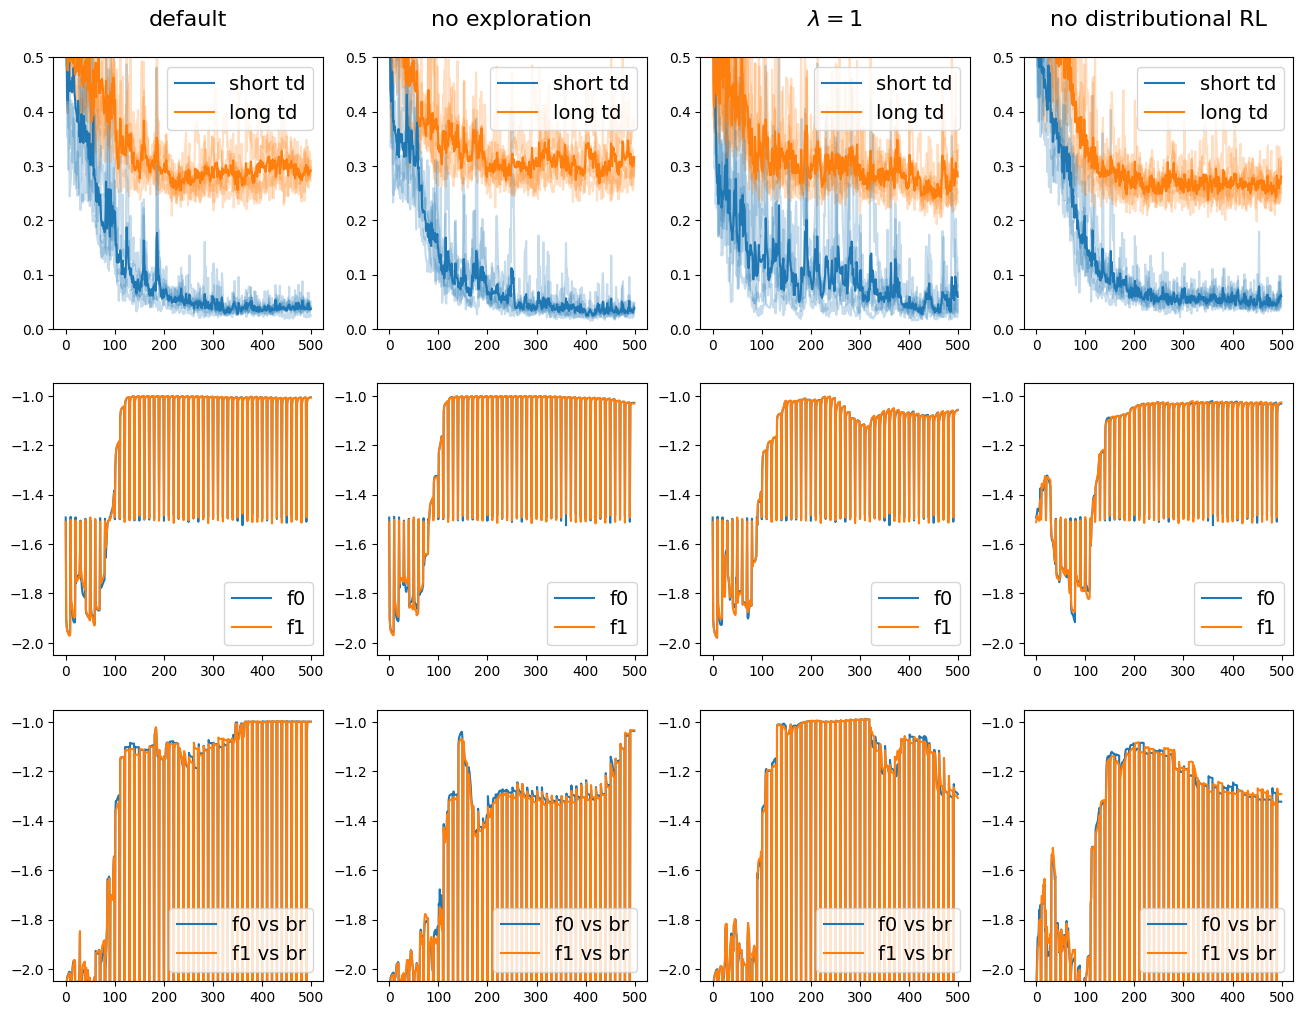

td0 0.05559089
no_target 0.04928746
no_uhat 0.05295936
fixed_gamma 0.22660105


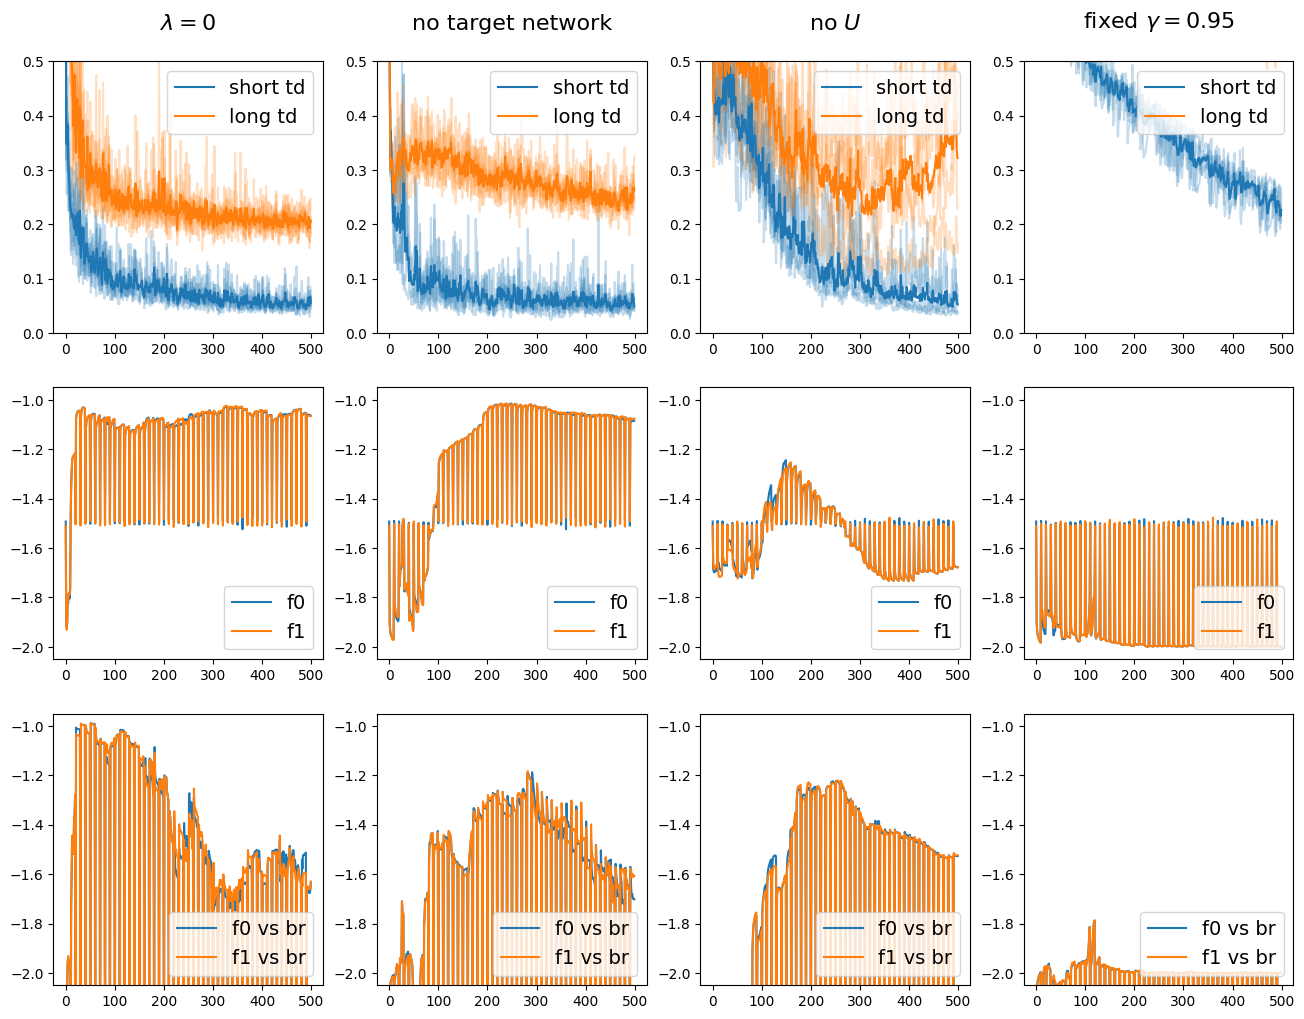

In [13]:
for variations in ["default no_explore no_lamda no_qrl".split(),
                    "td0 no_target no_uhat fixed_gamma".split()]:
  fig, axes = plt.subplots(3,len(variations),squeeze=False, figsize=(4*len(variations),4*3))
  for i, variation in enumerate(variations):
    trials = runs[variation]

    final_errors = []
    seqss = []
    for run in trials:
      seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])  # {k: [t]}
      seqss.append(seqs)
      final_errors.append(seqs["td"][-1])
      axes[0,i].plot(seqs["td"], alpha=0.25, color="tab:blue")
      axes[0,i].plot(seqs["longterm_td"], alpha=0.25, color="tab:orange")

    meanseq = deepmap(lambda *xs: sum(xs)/len(xs), *seqss)
    #meanseq = deepmap(lambda xs: np.lib.stride_tricks.sliding_window_view(xs, 30).mean(axis=-1), meanseq)
    axes[0,i].plot(meanseq["td"], color="tab:blue", label="short td")
    axes[0,i].plot(meanseq["longterm_td"], color="tab:orange", label="long td")
    axes[1,i].plot(meanseq["o95_f"][:,0], color="tab:blue", label="f0")
    axes[1,i].plot(meanseq["o95_f"][:,1], color="tab:orange", label="f1")
    axes[2,i].plot(meanseq["o95_x"][:,0], color="tab:blue", label="f0 vs br")
    axes[2,i].plot(meanseq["o95_x"][:,1], color="tab:orange", label="f1 vs br")
    print(variation, np.mean(final_errors))
    title = variation
    title = dict(
        default="default\n",
        no_uhat="no $U$\n",
        no_explore="no exploration\n",
        no_target="no target network\n",
        no_lamda="$\lambda=1$\n",
        no_qrl="no distributional RL\n",
        td0="$\lambda=0$\n",
        fixed_gamma="fixed $\gamma=0.95$\n",
    )[variation]
    axes[0,i].set_title(title, fontsize=16)
    #axes[1,i].set_title(title)
    axes[0,i].set_ylim((0,0.5))
    axes[1,i].set_ylim((-2.05,-0.95))
    axes[2,i].set_ylim((-2.05,-0.95))
    axes[0,i].legend(fontsize=14, loc="upper right")
    axes[1,i].legend(fontsize=14, loc="lower right")
    axes[2,i].legend(fontsize=14, loc="lower right")
  plt.show()